In [ ]:
# Scraper 설치
!pip install pyLDAvis # LDA 시각화
!pip install git+https://github.com/haven-jeon/PyKoSpacing.git # 한국어 띄어쓰기 패키지(pykospacing)
!pip install git+https://github.com/ssut/py-hanspell.git # 한국어 Norm : 맞춤법 교정(hanspell)

# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh
!pip install konlpy

! pip install MeCab
# 오류나면 [런타임 다시 시작] 누르고 다시 설치 필요 없이 진행 !!!!!

In [1]:
# Data 불러오기
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/Colab Notebooks/OTT_team_project

/content/drive/MyDrive/Colab Notebooks/OTT_team_project


In [ ]:
!pip install numpy==1.24.0 --force

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [3]:
import utils.LDA_utils as lda_utils

## 전처리 필요 라이브러리
import re
import time
import datetime
import numpy as np
import pandas as pd

# 단어 임베딩
from sklearn.manifold import TSNE
from gensim import models
import itertools

# 기타
from tqdm import tqdm
import warnings # 경고 메시지 무시
import matplotlib.pyplot as plt

warnings.filterwarnings(action='ignore')
plt.rcParams['font.family'] = 'Malgun Gothic'

## Main

Data preprocessing

In [4]:
# OTT 선택, 전체로 할 시 None 으로 기입
# OTT = 'tiving'
OTT = None

# 토픽 결정 수
num_topics = 5

# 불용어 
add_stopwords_list = ['티빙', '넷플릭스', '웨이브', '쿠팡', '쿠팡플레이', '디즈니', '나무',
                      '디즈니플러스', '애플리케이션', '개발자', '도도', '슈슈', '휴휴',
                      '옥수수', '라프텔', '라프']

timeslices=[4097, 16623, 3051]

In [5]:
# 데이터 불러오기
df = pd.read_csv('./data/google_store_review.csv', encoding='utf-8-sig')
if OTT: 
  df_ott = df[df['ott']== OTT]
else:
  df_ott = df.copy()


### 리뷰 기간 조정 및 결측치 처리 ###
df_ott = lda_utils.date_extract(df_ott, start_day='2021-11-12', printing=True)

### 토픽모델링 ###
token_data = lda_utils.Data_processing(df_ott) # 전처리 시작
tokenized_data, _ = token_data.get_token(add_stopwords_list)

2021: 4097 rows

2022: 16623 rows

2023: 3051 rows

ko_language done..
replace_word done..
tokenize done..
remove_stopwords done..


In [6]:
# Corpus 합쳐서 따로 Word Embedding
# tokenized_data = 모든 문장 토큰들 집합 [[1], [2], [3]] 형

# 1. Word2Vec

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

model = Word2Vec(sentences = tokenized_data, vector_size = 300, window = 5, min_count = 5, workers = 4, sg = 0)

# model.wv.save_word2vec_format('./data/word2vec_model') # 모델 저장
# loaded_model = KeyedVectors.load_word2vec_format("eng_w2v") # 모델 로드

print(model.wv.most_similar('손흥민'))

[('토트넘', 0.997668981552124), ('쓰레기', 0.9894750118255615), ('관리', 0.9852706789970398), ('사업자', 0.985161304473877), ('이용권', 0.9838922023773193), ('사이트', 0.9838410019874573), ('맵', 0.9838085174560547), ('절차', 0.9837981462478638), ('보상', 0.9835002422332764), ('가입자', 0.9821307063102722)]


In [7]:
# Fasttext

from gensim.models.fasttext import FastText

fasttext_model = FastText(sentences = tokenized_data, min_count=2, vector_size=300, window=5)
print(fasttext_model)

print(fasttext_model.wv.most_similar('손흥민'))


FastText<vocab=3874, vector_size=300, alpha=0.025>
[('토트넘', 0.9987761974334717), ('서버', 0.9976307153701782), ('사업자', 0.9973018169403076), ('전산', 0.9963969588279724), ('티켓', 0.9961538314819336), ('양반', 0.996029257774353), ('물류', 0.9959326386451721), ('선수', 0.9958610534667969), ('세이버', 0.9957892894744873), ('경기도', 0.9955552816390991)]


Word Embedding

In [ ]:
import itertools

t2021 = pd.read_csv('./data/LDA_results/2021_v2.csv', encoding = 'euc-kr')
t2022 = pd.read_csv('./data/LDA_results/2022_v2.csv', encoding = 'euc-kr')
t2023 = pd.read_csv('./data/LDA_results/2023_v2.csv', encoding = 'euc-kr')

def normalize(topic_):
    topic_ = topic_.iloc[0:20, :]
    for column in topic_:
        if type(topic_[column][0]) != str:
            x = topic_[column].values.reshape(-1, 1)
            tot = x.sum()
            x = x/tot
            topic_[column] = x
    return topic_

t2021 = normalize(t2021)
t2022 = normalize(t2022)
t2023 = normalize(t2023)

def wordlist(data_):
    v1 = data_['1_topic'].values
    v2 = data_['2_topic'].values
    v3 = data_['3_topic'].values
    v4 = data_['4_topic'].values
    v5 = data_['5_topic'].values
    wordlist_ = list(set(list(itertools.chain(v1, v2 ,v3, v4, v5))))
    return wordlist_

words = wordlist(t2021)

# word_sentiment = pd.read_csv('./data/words_sentiment.csv', encoding='cp949')

w2v_embedding = np.array([])
fast_embedding = np.array([])
i = 0
for word in words:
    if i == len(words):
        break
    # w2v_embedding = np.append(w2v_embedding, model.wv.get_vector(word))
    fast_embedding = np.append(fast_embedding, fasttext_model.wv.get_vector(word))
    i += 1

# 300차원 벡터로 표상, embedding reshape
# w2v_embedding = w2v_embedding.reshape(len(words), 300)
fast_embedding = fast_embedding.reshape(len(words), 300)

In [ ]:
tsne = TSNE(perplexity = 5, n_components = 2, init = 'pca', learning_rate = 100) #, n_iter = 10000, learning_rate = 100, early_exaggeration = 5)
w2v_word_embed = tsne.fit_transform(w2v_embedding)
fast_word_embed = tsne.fit_transform(fast_embedding)

w2v_dict = dict(zip(words, w2v_word_embed))
fast_dict = dict(zip(words, fast_word_embed))

def topicval(list_, dict_):
    df_ = pd.DataFrame(index = range(len(list_)), columns = ['Weight', 'Word', 'Val'])
    df_['Weight'] = list_.iloc[:, 1]
    df_['Word'] = list_.iloc[:, 0].map(dict_)
    df_['Val'] = df_['Weight'] * df_['Word']
    return [df_['Val'].sum()]

def gettopic(data_, dict_):
    tplist_ = np.array([])
    for i in range(0, 10, 2):
        data_i = data_.iloc[:, i:i+2]
        tplist_ = np.append(tplist_, [topicval(data_i, dict_)])
        tplist_ = tplist_.reshape((-1, 2))
    return tplist_

w_2021 = gettopic(t2021, w2v_dict)
w_2022 = gettopic(t2022, w2v_dict)
w_2023 = gettopic(t2023, w2v_dict)
w_all = np.concatenate([w_2021, w_2022, w_2023], axis = 0)

f_2021 = gettopic(t2021, fast_dict)
f_2022 = gettopic(t2022, fast_dict)
f_2023 = gettopic(t2023, fast_dict)
f_all = np.concatenate([f_2021, f_2022, f_2023], axis = 0)


In [ ]:
# 한글 깨짐 해결

import matplotlib.font_manager as fm
from matplotlib import rc

font_list = fm.findSystemFonts(fontpaths = None, fontext = 'ttf')
font_list[:]


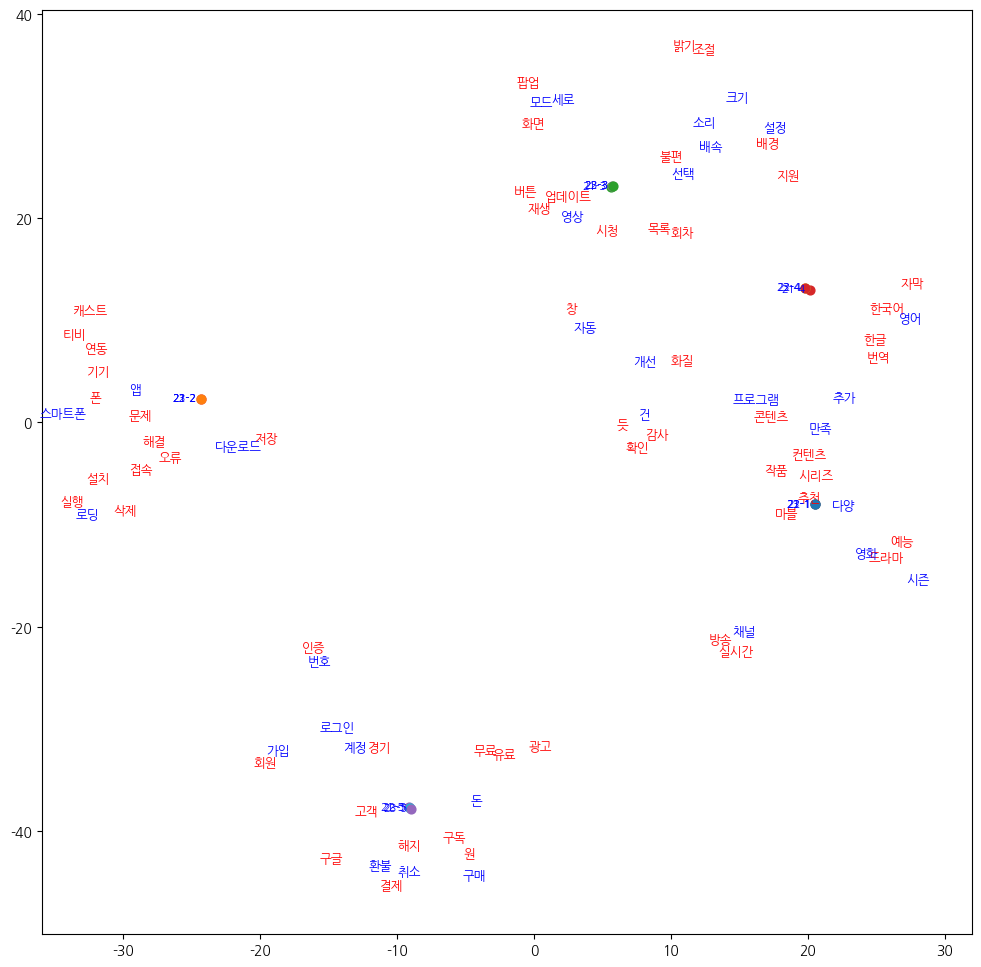

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic') 

import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

topic_label = []
for i in range(15):
    if i < 5:
        text = f'21-{i+1}'
    elif 4 < i < 10:
        text = f'22-{i-4}'
    elif 9 < i:
        text = f'23-{i-9}'
    topic_label.append(text)

def coloring(number_):
    if number_ == 0:
      return 'red'
    elif number_ == 1:
      return 'blue'


plt.figure(figsize=(12, 12))  # in inches
for i, label in enumerate(words):
    x, y = w2v_word_embed[i, :] # word2vec
    # x, y = fast_word_embed[i, :] # fasttext
    plt.scatter(x, y, color = 'white')
    plt.annotate(label,
                  xy=(x, y),
                  xytext=(0, 0),
                  textcoords='offset points',
                  ha='right',
                  va='bottom',
                  color = coloring(word_sentiment['BERT'][i]),
                  fontsize = 9)
for i, label in enumerate(topic_label):
    x, y = w_all[i, :] # word2vec
    # x, y = f_all[i, :] # fasttext
    plt.scatter(x, y, marker = 'o', s = 40) # color = 'limegreen',
    plt.annotate(label,
                 color = 'b',
                  xy=(x, y),
                  xytext=(-3, -3),
                  textcoords='offset points',
                  ha='right',
                  va='bottom',
                  fontsize = 8)
    

plt.savefig('./data/W2V_TSNE_Colored.png')  
# plt.savefig('./data/Fasttext_TSNE_Colored.png')
